# Chapter 4 of book: Mnist Basics - Under the hood: Training a Digit Classifier
https://nbviewer.org/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb

We will start by using computer vision to introduce fundamental tools and concepts for deep learning
- discuss the roles of arrays and tensors and of broadcasting, a powerful way to use them expressively
- stochastic gradient descent (SGD), mechanism for learning by updating weights automatically
- choice of a loss function for our basic classification task
- role of mini-batches
- describe the math that a basic neural network is actually doing

This chapter is a foundational chapter, all concepts depend on each other

First steps is to consider how images are represented in a computer

# Pixels: The Foundations of Computer Vision
In order to understand what happens in a computer vision model, we need to understand how computers handle images
We will use the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database
A dataset of images of handwritten digits

In [1]:
# install pytorch - https://pytorch.org/get-started/locally/
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())

current_device = torch.cuda.current_device()
print(torch.cuda.device(current_device))
print(torch.cuda.get_device_name(current_device))

True
1
NVIDIA GeForce RTX 3070


In [1]:
# for initial tutorial, we try to create a model for classifying any image as a 3 or 7
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)
print(path)

# see what is in this directory
# a method in fastai class called "L", like a list
# the .ls() method will print the count of items also
print(path.ls())

C:\Users\jerem\.fastai\data\mnist_sample
[Path('C:/Users/jerem/.fastai/data/mnist_sample/labels.csv'), Path('C:/Users/jerem/.fastai/data/mnist_sample/train'), Path('C:/Users/jerem/.fastai/data/mnist_sample/valid')]


In [4]:
# There are train and valid dataset in separate folders
(path/"train").ls()

# we say that "3" and "7" are the labels (or targets) in this dataset

(#2) [Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/7')]

In [2]:
# we will do a sorted on the files so that the order is the same
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

threes

(#6131) [Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/jerem/.fastai/data/mnist_sample/train/3/10091.png')...]

In [11]:
# taking a look at one of the three image
from PIL import Image
# help(Image)

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

We are using the `Image` class from Python Imaging Library (PIL), the most widely used Python package for opening, manipulating, and viewing images

In a computer, everything is represented as a number
To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor

In [14]:
# e.g. a section of the image, converted to NumPy array
# help(array)
# 4:10 means we request the rows from index 4 (included) to index 10 (not included).
# same for the columns
# NumPy indexes from top to bottom and left to right
# so we are seeing the top left corner of the image
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [15]:
# same thing, as a PyTorch tensor instead
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [27]:
# slice the array to pick just the part we want to see, then use Pandas DataFrame to color code the values using gradient
# to show how the image is created from the pixel values

# https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

import pandas as pd

img3_t = tensor(im3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{"font-size": "8pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


The background white pixels are stored as number 0, black is the number 255
Shades of grey are between 0 and 255
The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels

How would we program the computer to recognize these 2 different digits?

# First Try: Pixel Similarity
First idea: find the average pixel value of every pixel of the "3"s then do the same for the "7"s
We will have 2 group averages, defining what we might call the "ideal" 3 and 7
Then to classify an image, we will see which of the two digits they are more similar to

This will make a good baseline
- Baseline: simple model which you are confident should perform reasonably well
- Should be easy to implement, easy to test, so that you can test each of your improved ideas
- Without starting with a baseline, it is difficult to know whether your fancy models are doing any good
- Another good approach is to search around and find other people that have solved similar problems as yours, and download and run their code on your dataset

In [3]:
# Create a tensor containing all of our 3s stacked together
# Use python list comprehension to create a plain list of the single image tensors
seven_tensors = [tensor(Image.open(im7)) for im7 in sevens]
three_tensors = [tensor(Image.open(im3)) for im3 in threes]

len(three_tensors), len(seven_tensors)

(6131, 6265)

A list comprehension looks like this: `new_list: [f(o) for o in a_list if o > 10]`
- return every element of `a_list` that is greater than 10, after passing it through function `f`
- Three parts
    1) Collection you are iterating over (`a_list`)
    2) Optional filter (`if o > 10`)
    3) Something to do to each element (`f(o)`)

<Axes: >

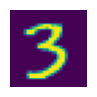

In [7]:
# check that one image looks okay
# need fastai show_image to display the tensor image, or else jupyter will print the tensor as values
show_image(three_tensors[1])

For every pixel position, we want to compute the average over all the images of the intensity of that pixel
We will first combine all the images in this list into a single three-dimensional tensor
- Described as rank-3 tensor

We often need to stack up individual tensors in a collection into a single tensor
PyTorch has a function `stack` that we can use for this purpose

Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types
Since we will need this later, we will cast our stacked tensor to float now

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will divide by 255 here

In [4]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

stacked_threes.shape

torch.Size([6131, 28, 28])

The most important attribute of a tensor is its `shape`
**shape** Tells the length of each axis
torch.Size([6131, 28, 28])
- 6131 images, each of size 28 x 28 pixels
- Nothing specifically about this tensor that says the first axis is the number of images, second is the height and third is width
- The semantics is entirely up to us and how we construct it
- For PyTorch, it is just a bunch of numbers in memory

**Length of a tensor's shape is its rank**
rank = len(stacked_threes.shape)
=> 3

In [8]:
len(stacked_threes.shape)

# RANK is the number of axes or dimensions in a tensor
# SHAPE is the size of each axis of a tensor

3

In [9]:
# Get tensor rank directly using ndim
stacked_threes.ndim # 3

3

torch.Size([28, 28])


<Axes: >

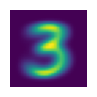

In [5]:
# we can calculate what the ideal 3 looks like
# calculate the mean of all the image tensors by taking mean along dimension 0 our stacked, rank 3 tensor
# this is the dimension that indexes over all the images

# For each pixel position, this will compute the average of that pixel over all images
# the result will be one value for each pixel position, or a single image

# mean over the first dimension
# tensor shape -> torch.Size([6131, 28, 28])
mean_three = torch.mean(stacked_threes, 0) # or stacked_threes.mean(0)

print(mean_three.shape) # will be torch.Size([28, 28])
show_image(mean_three) # show the ideal number 3

torch.Size([28, 28])


<Axes: >

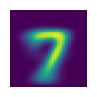

In [6]:
# get the mean of sevens!
mean_seven = torch.mean(stacked_sevens, 0)

print(mean_seven.shape)
show_image(mean_seven)

Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."

**stop: Stop and Think!:** How would you calculate how similar a particular image is to each of our ideal digits? 
Remember to step away from this book and jot down some ideas before you move on! 
Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

- Possible ideas
Take an image, take each pixel and calculate the mean squared error from the "ideal" three and "ideal" seven.
The one that is closer will be chosen as the possible image

How to determine the distance from our ideal 3?
We can't just add up the differences between the pixels of this image and the ideal digit
Some differences will be positive while others will be negative and these differences will cancel out, resulting in an image that is too dark in some areas and some that are too light in some areas to be shown as zero differences, which is misleading!

There are two main ways data scientists measure distance in this context
1) Take the mean of the absolute differences (absolute value is a function that replaces negative values with positive values). This is called **mean aboslute difference** or **L1 norm**
2) Take the mean of the square of differences (which makes everything positive) and then take the square root (does the unsquaring). This is **root mean squared error (RMSE) or L2 norm**

torch.Size([28, 28])
tensor(0.1114) tensor(0.2021)


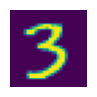

In [8]:
a_3 = stacked_threes[1]
print(a_3.shape)
show_image(a_3)

# L1 norm - take mean of the absolute value of differences
dist_3_abs = (a_3 - mean_three).abs().mean()
# L2 norm - take square root of (mean of square of differences) => root mean squared error (RMSE)
dist_3_sqr = ((a_3 - mean_three)**2).mean().sqrt()

print(dist_3_abs, dist_3_sqr)

In [11]:
# L1 norm - take absolute differences and get the mean
dist_7_abs = (a_3 - mean_seven).abs().mean()
# L2 norm - Root mean squared error RMSE - take squared differences, get mean, then do square root
dist_7_sqr = ((a_3 - mean_seven)**2).mean().sqrt()

print(dist_7_abs, dist_7_sqr)

tensor(0.1586) tensor(0.3021)


For both cases, the distance between our "3" and the "ideal" 3 is less than the distance to the ideal 7
So our simple model is right in this case

PyTorch already provides both of these as **loss functions**
These are inside `torch.nn.functional` which the PyTorch recommends importing as `F` (and is available by default under the name in fastai)

In [36]:
import torch.nn.functional as F

# help(F)

help(F.l1_loss)
help(F.mse_loss)

# L1 norm, take mean of absolute differences
print("L1 norm")
print(F.l1_loss(input=a_3.float(), target=mean_three), F.l1_loss(input=a_3, target=mean_seven))

# L2 norm, take sqrt of mean of squared differences, need to sqrt after calling F.mse_loss
# https://discuss.pytorch.org/t/rmse-loss-function/16540
print("\nL2 norm, AKA Root mean squared error")
print(F.mse_loss(input=a_3.float(), target=mean_three).sqrt(), F.mse_loss(input=a_3, target=mean_seven).sqrt())

# mse means mean squared error, l1 refers to the standard mathematical jargon for mean absolute value (in math its called L1 norm)

Help on function l1_loss in module torch.nn.functional:

l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor
    l1_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor
    
    Function that takes the mean element-wise absolute value difference.
    
    See :class:`~torch.nn.L1Loss` for details.

Help on function mse_loss in module torch.nn.functional:

mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor
    mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor
    
    Measures the element-wise mean squared error.
    
    See :class:`~torch.nn.MSELoss` for details.

L1 norm
tensor(0.1114) tensor(0.1586)

L2 norm, AKA Root mean squared error
tensor(0.2021) tensor(0.3021)


# Difference between L1 norm and mean squared error (MSE) is that MSE will penalize bigger mistakes more heavily than L1 norm (and be more lenient with small mistakes)

We completed various mathematical operations on PyTorch tensors. If you have done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays

# NumPy Arrays and PyTorch Tensors
NumPy is the most widely used library for scientific and numeric programming in Python
Provides similar functionality and API as PyTorch BUT it does not support using the GPU or calculating gradients, which are both critical for deep learning

We will therefore generally use PyTorch tensors instead of NumPy arrays, whenever possible

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C.
**NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

A NumPy array is a multidimensional table of data, with all items of the same type. This can be any type, they can even be arrays of arrays, with the innermost arrays being different sizes (jagged array)
By multidimensional table, we mean, e.g. list (dimension of one), table or matrix (dimension of two), table of tables or cube (dimension of three), and so forth
If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory (where NumPy shines)
NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

    S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

In [42]:
"""
Create an array or tensor => pass a list (or list of lists, or list of lists of lists, etc) 
to `array()` (NumPy) or `tensor()` (PyTorch)
"""
data = [[1,2,3],[4,5,6]]
arr = array(data) # NumPy
tns = tensor(data) # PyTorch

# All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

# Select a row (note that, like lists in Python, tensors are 0-indexed, index 1 refers to second row/column)
print(tns[1]) # tensor([4,5,6])

tensor([4, 5, 6])


In [48]:
# or a column, by using `:` to indicate all of the first axis (we sometimes refer to dimension of tensors/arrays as axes
print(tns[:, 1]) # tensor([2, 5])

# e.g. drop first row of each entry
print(tns[1:])

# can give python slice syntax (e.g. [start : end])
print(tns[1, 1:3]) # get second entry, slice from 2 element 2 item => tensor([5, 6])

# And you can use the standard operators such as +, -, *, /:
print(tns + 1) # tensor([[2,3,4],[5,6,7]])

# tensors have a type
print(tns.type()) # torch.LongTensor

# will auto change type as needed, e.g. from int to float
print(tns * 1.5)
print((tns * 1.5).type())

tensor([2, 5])
tensor([[4, 5, 6]])
tensor([5, 6])
tensor([[2, 3, 4],
        [5, 6, 7]])
torch.LongTensor
tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])
torch.FloatTensor


So, is our baseline model any good? To quantify this, we must define a metric.

# Computing Metrics Using Broadcasting
